In [19]:
import torch
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

class ContrastiveDataset(Dataset):
    def __init__(self, n=10000, num_groups=10):
        self.n = n
        self.num_groups = num_groups
        self.range_size = self.n // self.num_groups
        self.ranges = [
            (self.range_size * i, self.range_size * (i + 1)) for i in range(self.num_groups)
        ]

        # Handle any remaining samples by adding them to the last range
        if self.range_size * self.num_groups < self.n:
            self.ranges[-1] = (self.ranges[-1][0], self.n)

        # Assign group labels to each index for visualization
        self.labels = torch.zeros(self.n, dtype=torch.long)
        for i in range(self.num_groups):
            start, end = self.ranges[i]
            self.labels[start:end] = i

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        anchor = idx

        range_idx = anchor // self.range_size
        if range_idx >= self.num_groups:
            range_idx = self.num_groups - 1  # Correct adjustment

        start, end = self.ranges[range_idx]
        positive_sample = torch.randint(start, end, (1,)).item()

        return torch.tensor(anchor, dtype=torch.long), torch.tensor(positive_sample, dtype=torch.long)

class Encoder(torch.nn.Module):
    def __init__(self, n):
        super(Encoder, self).__init__()
        self.embedding = torch.nn.Embedding(n, 768)
        self.fc = torch.nn.Linear(768, 768)
        self.non_linearity = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(768, 768)
        #self.non_linearity2 = torch.nn.Tanh()

    def forward(self, x):
        emb = self.embedding(x)
        out = self.fc(emb)
        out = self.non_linearity(out)
        out = self.fc2(out)
        return out
   
def initialize_queue():
    # Total number of samples in the dataset
    n = len(dataset)

    # Number of keys to sample for the queue
    queue_size = 1000

    # Randomly sample 1000 indices from the dataset
    key_indices = random.sample(range(n), queue_size)

    # Convert to a tensor
    key_indices = torch.tensor(key_indices, dtype=torch.long)

    # Ensure the key encoder is on the correct device (e.g., CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    encoder_k.to(device)
    key_indices = key_indices.to(device)

    # Set the key encoder to evaluation mode
    encoder_k.eval()

    # Disable gradient computation for the key encoder
    with torch.no_grad():
        # Obtain key embeddings
        queue = encoder_k(key_indices)
    return queue

# Number of unique items in the dataset
n = 10000

# Initialize the query encoder (encoder_q)
encoder_q = Encoder(n)
encoder_k = Encoder(n)

# Copy the parameters from encoder_q to encoder_k
encoder_k.load_state_dict(encoder_q.state_dict())

# Create an instance of your dataset
dataset = ContrastiveDataset(n=10000, num_groups=10)

# Set the batch size
batch_size = 25

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

queue=initialize_queue()
print(queue)

def update_key_encoder(encoder_q, encoder_k, m):
    for param_q, param_k in zip(encoder_q.parameters(), encoder_k.parameters()):
        param_k.data = m * param_k.data + (1 - m) * param_q.data

def train(encoder_q, encoder_k, dataset, num_epochs=10, batch_size=25, queue_size=1000, m=0.999, lr=0.0001):
    """
    Training function for the MoCo algorithm.

    Parameters:
    - encoder_q: The query encoder (updated via backpropagation).
    - encoder_k: The key encoder (momentum encoder).
    - dataset: The ContrastiveDataset instance.
    - num_epochs: Number of training epochs.
    - batch_size: Batch size for training.
    - queue_size: Size of the queue for negative samples.
    - m: Momentum coefficient for updating the key encoder.
    - lr: Learning rate for the optimizer.
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    encoder_q.to(device)
    encoder_k.to(device)

    # Initialize the queue with key embeddings
    # Randomly sample indices for initialization
    n = len(dataset)
    initial_indices = torch.randperm(n)[:queue_size].to(device)
    with torch.no_grad():
        encoder_k.eval()
        queue = encoder_k(initial_indices)
        queue = torch.nn.functional.normalize(queue, dim=1)
    queue_ptr = 0  # Pointer for the circular queue

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define optimizer for encoder_q
    optimizer = torch.optim.SGD(encoder_q.parameters(), lr=lr)

    # Define loss function (Contrastive loss)
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        encoder_q.train()
        for anchors, positives in dataloader:
            # Move data to device
            anchors = anchors.to(device)
            positives = positives.to(device)

            # -------------------
            # Compute query features
            queries = encoder_q(anchors)      # Shape: [batch_size, embedding_dim]
            #queries = torch.nn.functional.normalize(queries, dim=1)

            # Compute key features using encoder_k (no gradients)
            with torch.no_grad():
                keys = encoder_k(positives)  # Shape: [batch_size, embedding_dim]
                #keys = torch.nn.functional.normalize(keys, dim=1)
           
            keys=keys.detach()

            # Define N, C, K
            N = queries.shape[0]  # Current batch size
            C = queries.shape[1]  # Embedding dimension
            K = queue.shape[0]    # Queue size

            # -------------------
            # Compute logits
            # Positive logits: similarity between queries and positive keys
            l_pos = torch.bmm(queries.view(N, 1, C), keys.view(N, C, 1)).squeeze(-1)  # Shape: [N, 1]

            # Negative logits: similarity between queries and all keys in the queue
            l_neg = torch.mm(queries, queue.t())   # Shape: [N, K]

            # Concatenate logits
            logits = torch.cat([l_pos, l_neg], dim=1)  # Shape: [N, 1 + K]

            # Apply temperature
            temperature = 0.1
            logits /= temperature

            # Labels: positive key is the 0-th in the concatenated logits
            labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)

            # -------------------
            # Compute loss
            loss = criterion(logits, labels)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # -------------------
            # Update key encoder using momentum
            with torch.no_grad():
                for param_q, param_k in zip(encoder_q.parameters(), encoder_k.parameters()):
                    param_k.data = m * param_k.data + (1 - m) * param_q.data

            # -------------------
            # Update the queue
            batch_size_curr = keys.shape[0]
            if queue_ptr + batch_size_curr <= queue_size:
                queue[queue_ptr:queue_ptr + batch_size_curr] = keys
            else:
                overflow = (queue_ptr + batch_size_curr) - queue_size
                queue[queue_ptr:] = keys[:batch_size_curr - overflow]
                queue[:overflow] = keys[batch_size_curr - overflow:]
            queue_ptr = (queue_ptr + batch_size_curr) % queue_size  # Move pointer

        # Optionally, print progress
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    return encoder_q

    print('Training completed.')

# Call the train function
encoder_q=train(encoder_q, encoder_k, dataset, num_epochs=500, batch_size=25, queue_size=8000, m=0.5, lr=0.0001)

tensor([[ 0.3143, -0.2465,  0.1196,  ..., -0.2408, -0.1092,  0.6965],
        [-0.1285,  0.0098,  0.2839,  ..., -0.4823, -0.1701, -0.1161],
        [ 0.7101,  0.0495,  0.0566,  ..., -0.1063, -0.2372,  0.0268],
        ...,
        [ 0.1322,  0.0658, -0.2036,  ...,  0.2023, -0.4046, -0.1498],
        [ 0.2374, -0.2881, -0.0846,  ..., -0.4099,  0.3343, -0.0467],
        [-0.1955, -0.2030, -0.3164,  ...,  0.3422,  0.0321,  0.2128]],
       device='cuda:0')
Epoch [1/500], Loss: 253.4782
Epoch [2/500], Loss: 168.8495
Epoch [3/500], Loss: 157.7733
Epoch [4/500], Loss: 104.4876
Epoch [5/500], Loss: 101.3285
Epoch [6/500], Loss: 79.7933
Epoch [7/500], Loss: 60.8254
Epoch [8/500], Loss: 50.1874
Epoch [9/500], Loss: 48.8082
Epoch [10/500], Loss: 37.0067
Epoch [11/500], Loss: 28.4628
Epoch [12/500], Loss: 27.6802
Epoch [13/500], Loss: 26.4546
Epoch [14/500], Loss: 21.5284
Epoch [15/500], Loss: 16.4212
Epoch [16/500], Loss: 17.7616
Epoch [17/500], Loss: 18.1663
Epoch [18/500], Loss: 18.3923
Epoch 

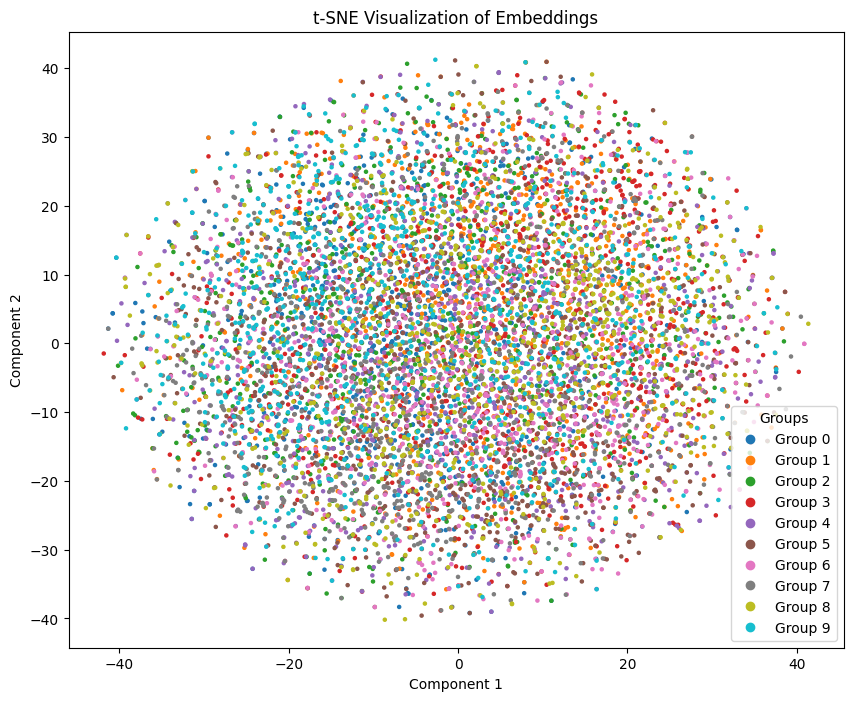

In [15]:
device='cuda'# After training, encode all 10,000 indices
encoder_q.eval()  # Set the encoder to evaluation mode

# Generate indices from 0 to 9999
all_indices = torch.arange(0, 10000, dtype=torch.long).to(device)

# Get embeddings
with torch.no_grad():
    embeddings = encoder_q(all_indices).cpu().numpy()  # Move embeddings to CPU and convert to NumPy array

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Get labels for color-coding
labels = dataset.labels.numpy()

# Plot the embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', s=5)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Group {i}' for i in range(dataset.num_groups)], title='Groups')
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Accuracy: 0.2440
Classification Report:
              precision    recall  f1-score   support

           0     0.2589    0.2550    0.2569       200
           1     0.2524    0.2600    0.2562       200
           2     0.2919    0.2350    0.2604       200
           3     0.2059    0.2100    0.2079       200
           4     0.2983    0.2700    0.2835       200
           5     0.2279    0.2450    0.2361       200
           6     0.2240    0.2150    0.2194       200
           7     0.2209    0.2750    0.2450       200
           8     0.2217    0.2550    0.2372       200
           9     0.2667    0.2200    0.2411       200

    accuracy                         0.2440      2000
   macro avg     0.2469    0.2440    0.2444      2000
weighted avg     0.2469    0.2440    0.2444      2000



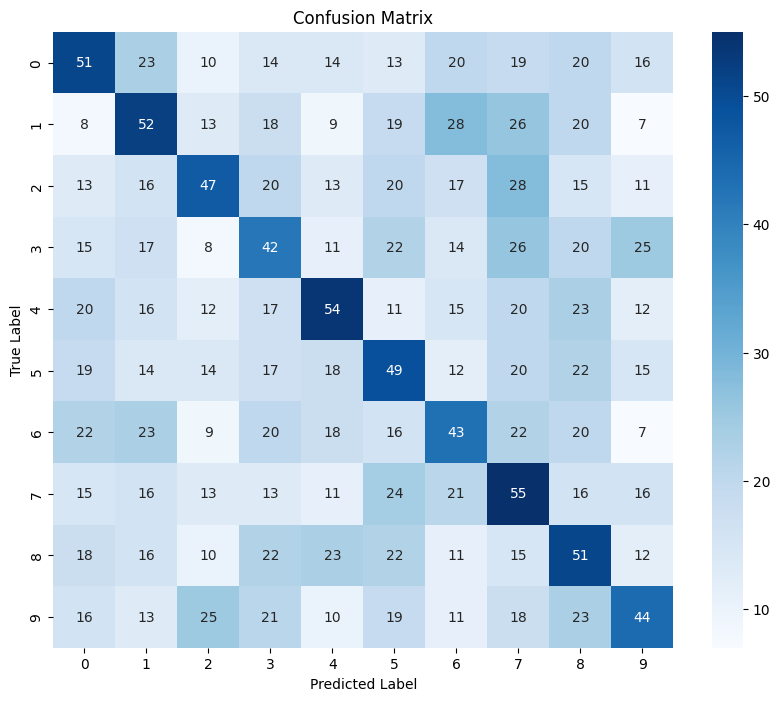

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
log_reg = LogisticRegression(
    multi_class='multinomial',  # For multi-class classification
    solver='lbfgs',             # Optimizer suitable for multinomial loss
    max_iter=1000,              # Increase max iterations to ensure convergence
    n_jobs=-1                   # Use all available CPU cores
)

# Train the model
log_reg.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate classification report
report = classification_report(y_test, y_pred, digits=4)
print('Classification Report:')
print(report)

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(dataset.num_groups)],
            yticklabels=[str(i) for i in range(dataset.num_groups)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
